In [1]:
import warnings
warnings.filterwarnings('ignore')
import os, shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.models import load_model,Sequential
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Loading Data

In [116]:
train=pd.read_csv('C:/Users/reya.sadhu/Downloads/train/train.csv')
test=pd.read_csv('C:/Users/reya.sadhu/Downloads/test.csv')

In [77]:
train.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


In [117]:
test.head()

,image
0,1007700.jpg
1,1011369.jpg
2,1051155.jpg
3,1062001.jpg
4,1069397.jpg


In [78]:
train[train.isnull().any(axis=1)]

,image,category


So, there is no null values.

In [123]:
ship={1:'Cargo',2:'Military',3:'Carrier',4:'Cruise',5:'Tankers'}
train['ship']=train['category'].map(ship).astype('category')

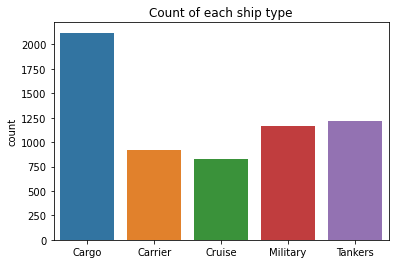

In [124]:
plt.title('Count of each ship type')
sns.countplot(train['ship'].values)
plt.show()

In [83]:
train['ship'].value_counts(normalize=True)

Cargo       0.339091
Tankers     0.194658
Military    0.186660
Carrier     0.146513
Cruise      0.133077
Name: ship, dtype: float64

Since there are class imbalances in training set,  We will stratify train_test_split in order to maintain the class distributions in both train and test.

There are 5 different labels. So we will hot encode the labels.

In [84]:
from sklearn.preprocessing import OneHotEncoder
encoder=OneHotEncoder(dtype='int8',sparse=False)
y=encoder.fit_transform(train['category'].values.reshape(-1,1))

In [119]:
y.shape

(6252, 5)

# Loading the images

We need to reshape each iamge to a particular size before feeding it into the network. Here we choose the shape (224,224). We also need to normalize the pixel value so that they have value in between 0-1. The pixel values of RGB image lies from 0 to 255. So, we divide each pixel value by 255. 

In [86]:
path='C:/Users/reya.sadhu/Downloads/train/images'
def load_and_process(what):
    imgs = []
    if what =='train':
        for file in tqdm(train['image'].values):
            img = load_img(os.path.join(path, file), target_size=(224,224))
            img = img_to_array(img)/255.
            imgs.append(img)
    elif what =='test':
        for file in tqdm(test['image'].values):
            img = load_img(os.path.join(path, file), target_size=(224,224))
            img = img_to_array(img)/255. 
            imgs.append(img)
    gc.collect()
    return np.asarray(imgs)

In [87]:
train_imgs = load_and_process('train')
test_imgs = load_and_process('test')
print(f'train shape: {train_imgs.shape}')
print(f'test shape: {test_imgs.shape}')

100%|█████████████████████████████████████████████████████████████████████████████| 2680/2680 [00:07<00:00, 347.61it/s]


train shape: (6252, 224, 224, 3)
test shape: (2680, 224, 224, 3)


So, output images are of proper size.

# Visualizing images

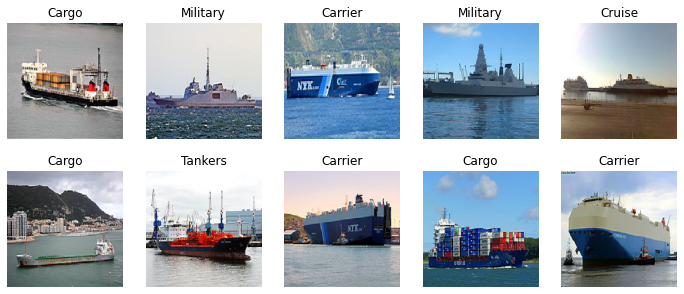

21626

In [88]:
plt.figure(figsize=(12,5))

for i in range(1,11):
    plt.subplot(2,5,i)
    plt.title(f'{train["ship"].values[i]}')
    plt.imshow(train_imgs[i])
    plt.axis('off')
plt.show()
gc.collect()

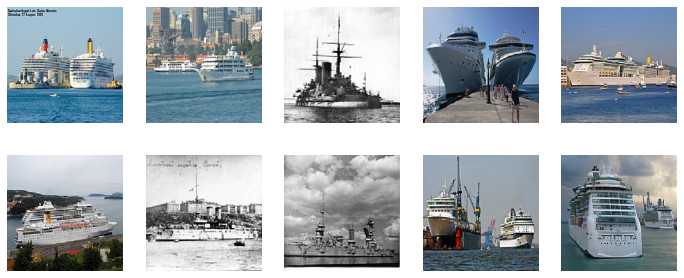

23759

In [90]:
plt.figure(figsize=(12,5))

for i in range(1,11):
    plt.subplot(2,5,i)
    plt.imshow(test_imgs[i])
    plt.axis('off')
plt.show()
gc.collect()

So, in the test set, there are greyscale images with color images. Also, some images contain a large portion of the background. So, to address these issues, we will need to perform data augmentation to create a more robust training set. This will also prevent overfitting.

# Splitting data into train and validation set

In [93]:
X_train, X_val, y_train, y_val = train_test_split(train_imgs, y, stratify=y, test_size=0.20, random_state=1)

We use stratify to maintain the class distribution in the training and validation set

# Training data augmentation

In [ ]:
BS = 8
gen = ImageDataGenerator(rotation_range=45, 
                         horizontal_flip=True, 
                         width_shift_range=0.5, 
                         height_shift_range=0.5)

train_generator = gen.flow(X_train, y_train,batch_size=BS)

# Fitting a pretrained model

In [102]:
from tensorflow.keras.applications.xception import Xception
model=models.Sequential([
    layers.Input((224,224,3)),
    Xception(include_top=False),
    GlobalAveragePooling2D(),
    Dense(5, activation='softmax')
])


In [114]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, None, None, 2048)  20861480  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 10245     
Total params: 20,871,725
Trainable params: 20,817,197
Non-trainable params: 54,528
_________________________________________________________________


In [103]:
lr=0.0001
epoch=20

model.compile(loss='categorical_crossentropy', 
              metrics=['accuracy'],
              optimizer=Adam(lr=lr,decay=lr/epoch))

In [104]:
history = model.fit_generator(train_generator, 
                    steps_per_epoch=len(X_train)//BS, 
                    validation_data=(X_val,y_val),
                    epochs=epoch)

Epoch 1/20
625/625 [==============================] - 1524s 2s/step - loss: 0.7429 - accuracy: 0.7116 - val_loss: 0.3218 - val_accuracy: 0.8865
Epoch 2/20
625/625 [==============================] - 1534s 2s/step - loss: 0.4518 - accuracy: 0.8352 - val_loss: 0.2151 - val_accuracy: 0.9257
Epoch 3/20
625/625 [==============================] - 1571s 3s/step - loss: 0.3522 - accuracy: 0.8722 - val_loss: 0.2885 - val_accuracy: 0.9097
Epoch 4/20
625/625 [==============================] - 1566s 3s/step - loss: 0.3316 - accuracy: 0.8768 - val_loss: 0.2457 - val_accuracy: 0.9153
Epoch 5/20
625/625 [==============================] - 1580s 3s/step - loss: 0.2856 - accuracy: 0.8943 - val_loss: 0.2364 - val_accuracy: 0.9305
Epoch 6/20
625/625 [==============================] - 1582s 3s/step - loss: 0.2444 - accuracy: 0.9137 - val_loss: 0.2104 - val_accuracy: 0.9353
Epoch 7/20
625/625 [==============================] - 1532s 2s/step - loss: 0.2336 - accuracy: 0.9145 - val_loss: 0.2435 - val_accuracy:

# Evaluating the model

In [120]:
pred1 = np.argmax(model.predict(X_train), axis=1)
f1_train = f1_score(np.argmax(y_train, axis=1), pred1, average='weighted')
print("Train F1 Score: {:.4f}".format(f1_train))

Train F1 Score: 0.9942


In [105]:
pred = np.argmax(model.predict(X_val), axis=1)
f1 = f1_score(np.argmax(y_val, axis=1), pred, average='weighted')
print("Valid F1 Score: {:.4f}".format(f1))

Valid F1 Score: 0.9436


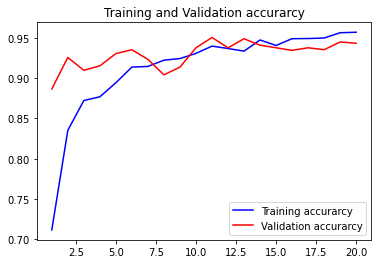

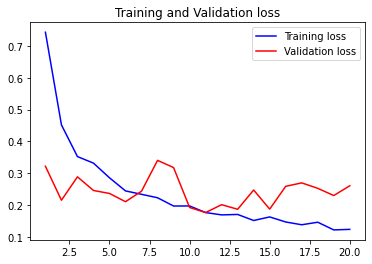

In [106]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

 - Training loss becomes almost flat at the end of the epochs. So, the model is not significantly underfitting.
 ## 
 - There is no significant gap between training and validation accuracy. But, validation loss increases after a certain point. The training could have been stopped at that point. Because, at the end of 20 epochs, the model overfits.
 ##  
 - Training loss curve is not noisy. So, the learning rate is suitable.

# Test predictions

argmax gives the index of the largest value. And python is zero indexed. But here we are using labels for ship from 1. So, we add 1 with each prediction to get the category.

In [107]:
sub=pd.read_csv('C:/Users/reya.sadhu/Downloads/sample.csv')
sub['category']=np.argmax(model.predict(test_imgs),axis=1)+1
sub.head()

,image,category
0,1007700.jpg,4
1,1011369.jpg,4
2,1051155.jpg,4
3,1062001.jpg,2
4,1069397.jpg,4


In [129]:
sub.to_csv('final.csv',index=False)